<a href="https://colab.research.google.com/github/bdknguyen/npb-198-final-project/blob/main/semantic_rep_network_model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import scipy.cluster.hierarchy as shc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)

In [ ]:
# Mount drive to access files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/NPB 198 Final Project

Mounted at /content/drive
/content/drive/My Drive/NPB 198 Final Project


# Stage 1: Data Loading/Organization

In [ ]:
# Extract output data from IS/ISA/CAN/HAS data csv's into dataframes
is_output = pd.read_csv("sem rep IS data.csv", delimiter=",", header=0, index_col=0)
isa_output = pd.read_csv("sem rep ISA data.csv", delimiter=",", header=0, index_col=0)
can_output = pd.read_csv("sem rep CAN data.csv", delimiter=",", header=0, index_col=0)
has_output = pd.read_csv("sem rep HAS data.csv", delimiter=",", header=0, index_col=0)

In [ ]:
# Extracts lists of animals and attributes from dataframes
animals_list = is_output.index.values
attributes_list = is_output.columns.values

# Create list of relation names
relations_list = ["IS", "ISA", "CAN", "HAS"]

In [ ]:
# Turn dataframes into tensors for outputs
is_output_numpy = is_output.to_numpy()
isa_output_numpy = isa_output.to_numpy()
can_output_numpy = can_output.to_numpy()
has_output_numpy = has_output.to_numpy()

In [ ]:
# Make lists of animal and relation inputs

animal_inputs = [[1,0,0,0,0,0,0,0], # grizzly bear
                [0,1,0,0,0,0,0,0], # black bear
                [0,0,1,0,0,0,0,0], # bald eagle
                [0,0,0,1,0,0,0,0], # golden eagle
                [0,0,0,0,1,0,0,0], # salmon
                [0,0,0,0,0,1,0,0], # trout
                [0,0,0,0,0,0,1,0], # caribou
                [0,0,0,0,0,0,0,1]] # moose

relation_inputs = [[1,0,0,0], # IS
                  [0,1,0,0], # ISA
                  [0,0,1,0], # CAN
                  [0,0,0,1]] # HAS

In [ ]:
# Stuff inputs and outputs for each relation into lists of tuples
# Then stuff lists into DataLoaders
# Format of data: ((Animal input, relation input), relation-specific output)

is_IO = []
for i in range(8):
  is_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[0]).float()),
      torch.tensor(is_output_numpy[i]).float())
      )

isa_IO = []
for i in range(8):
  isa_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[1]).float()),
      torch.tensor(isa_output_numpy[i]).float())
      )
  
can_IO = []
for i in range(8):
  can_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[2]).float()),
      torch.tensor(can_output_numpy[i]).float())
      )
  
has_IO = []
for i in range(8):
  has_IO.append(
      ((torch.tensor(animal_inputs[i]).float(), 
        torch.tensor(relation_inputs[3]).float()),
      torch.tensor(has_output_numpy[i]).float())
      )

# Combine all inputs/outputs into one unified list
all_IO = is_IO + isa_IO + can_IO + has_IO

is_IO_DataLoader = DataLoader(is_IO, batch_size=1, shuffle=False)
isa_IO_DataLoader = DataLoader(isa_IO, batch_size=1, shuffle=False)
can_IO_DataLoader = DataLoader(can_IO, batch_size=1, shuffle=False)
has_IO_DataLoader = DataLoader(has_IO, batch_size=1, shuffle=False)
all_IO_DataLoader = DataLoader(all_IO, batch_size=1, shuffle=True)

In [ ]:
# Sets order of relation dataloaders for testing each relation
relation_DL_order = [is_IO_DataLoader,
                     isa_IO_DataLoader,
                     can_IO_DataLoader,
                     has_IO_DataLoader]

# Stage 2: Network Setup

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(8, 8) # representation layer
    self.fc2 = nn.Linear(12, 15) # hidden layer
    self.fc3 = nn.Linear(15, 36) # attribute layer

    # Initialize weights for all layers
    torch.nn.init.uniform_(self.fc1.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc2.weight, a=-0.9, b=0.9)
    torch.nn.init.uniform_(self.fc3.weight, a=-0.9, b=0.9)
  
  def forward(self, data):
    # Extract animal/relation inputs from "data" tuple
    # x = animal, y = relation
    x, y = data

    # Animal input to representation layer, save representation data in var
    fc1 = self.fc1(x)
    x = torch.sigmoid(fc1)

    # Concatenate rep layer output and relation input
    combined = torch.cat((x, y), dim=1)

    # Send concatenated input to hidden layer
    fc2 = self.fc2(combined)
    x = torch.sigmoid(fc2)

    # Hidden layer to attribute layer
    fc3 = self.fc3(x)
    output = torch.sigmoid(fc3)
    return output

# Stage 3: Training and Testing

In [ ]:
# Set learning rate, momentum, and num of epochs
learning_rate = 0.1
momentum = 0
num_epochs = 3500

# Make network and set up optimizer for backpropagation
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=0)

In [ ]:
# Set up function for extracting representation layer data
def get_hidden_features(x, layer):
    activation = {}

    def get_activation(name):
        def hook(network, input, output):
          activation[name] = output.detach()
        return hook

    rep_list = []
    hook = network.fc1.register_forward_hook(get_activation(layer))
    passthru = network(x)
    rep_list.append(activation[layer])
    hook.remove()
    return rep_list[0]

In [ ]:
# Set up function for network training
def train(epoch):
  network.train()
  train_loss = 0

  # Run through all data in dataloader
  for data, target in all_IO_DataLoader:
    output = network(data)
    loss = nn.CrossEntropyLoss()
    loss_amount = loss(output, target)
    train_loss += loss_amount

    optimizer.zero_grad()
    loss_amount.backward()
    optimizer.step()

  # Print out training progress for each relation dataset every 350 epochs
  train_loss /= len(all_IO_DataLoader)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("Train Epoch {}: \tLoss: {:.6f}".format(
      epoch, train_loss))

In [ ]:
# Set up function for testing
def test(epoch):
  network.eval()

  with torch.no_grad():
    if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
      for i in range(4):
        test_loss = 0

        for index, (data, target) in enumerate(relation_DL_order[i]):
          output = network(data)
          loss = nn.CrossEntropyLoss()
          test_loss += loss(output, target)

        test_loss /= len(relation_DL_order[i])
        print("Test: {}\tAverage loss = {:.6f}".format(relations_list[i], 
                                                      test_loss))  

In [ ]:
# Create bar graphs of animal representation data
def create_rep_graphs(epoch):
  # Create list of values for representation data
  rep_values_list = []

  with torch.no_grad():
    fig, ax = plt.subplots(8, sharex=True, figsize=(8,35))
    fig.suptitle(f"Animal Representation Data, Epoch {epoch}", y=0.905)
    for index, (data, target) in enumerate(relation_DL_order[0]):
      labels = np.arange(8)
      values = get_hidden_features(data, 'fc1')
      values = values.numpy()[0]
      rep_values_list.append(values)
      ax[index].bar(labels, values)
      ax[index].set_title(animals_list[index].upper())
  
  return rep_values_list

In [ ]:
# Create dendrograms of representation data at certain epoch
def create_dendrogram(rep_values_list, epoch):
  # Create dataframe of representation values
  rep_values_df = pd.DataFrame(np.array(rep_values_list), index=animals_list)

  # Make the graph
  plt.figure(figsize=(12, 6), dpi= 80)  
  plt.title(f"Animal Hierarchy, Epoch {epoch}", fontsize=22)
  dend = shc.dendrogram(shc.linkage(rep_values_df, method='ward'), 
                        labels=animals_list, color_threshold=100)
  plt.xticks(fontsize=12)
  plt.show()  

Train Epoch 1: 	Loss: 9.991426
Test: IS	Average loss = 4.508213
Test: ISA	Average loss = 15.012896
Test: CAN	Average loss = 10.233887
Test: HAS	Average loss = 9.776649




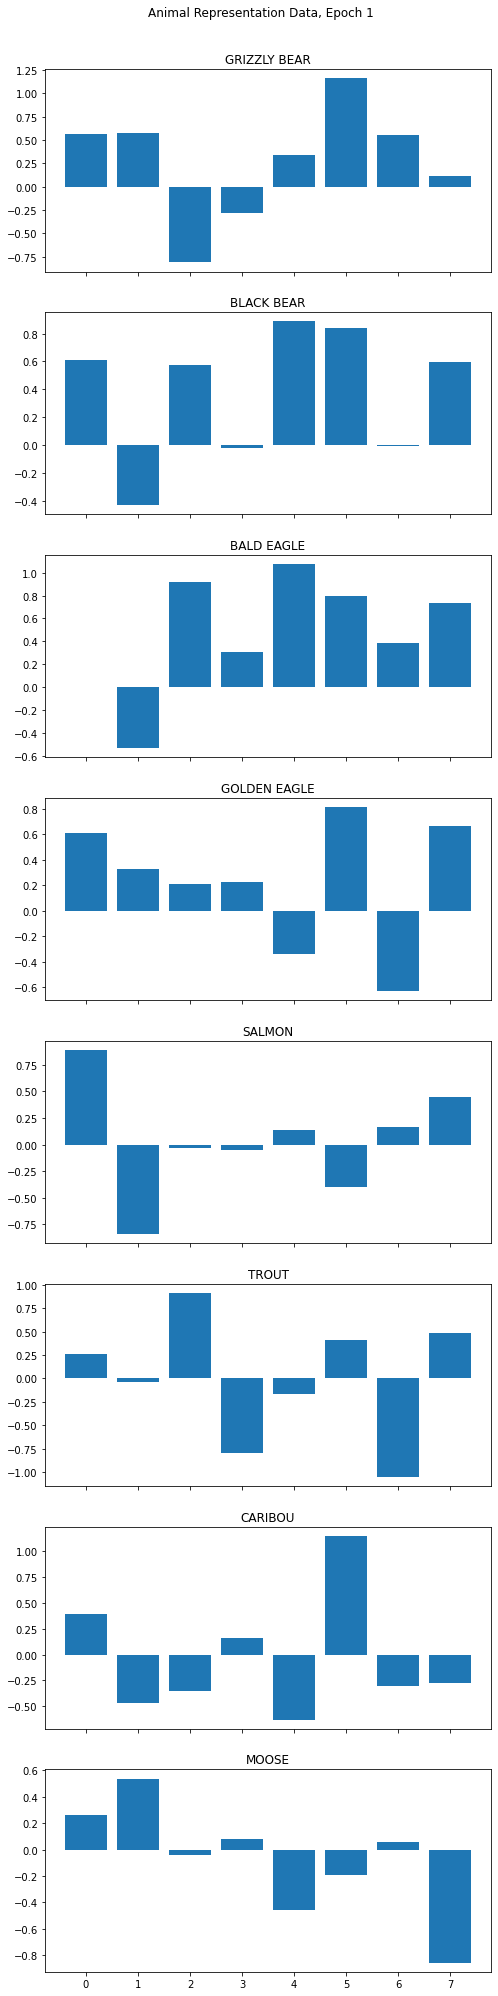

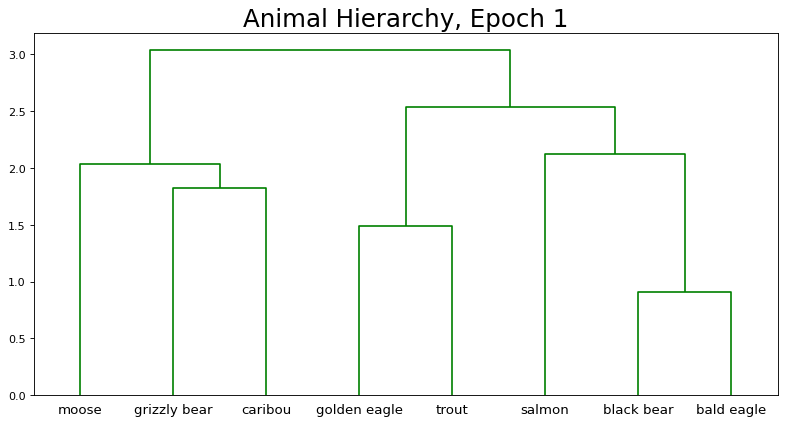

Train Epoch 175: 	Loss: 8.406694
Test: IS	Average loss = 3.694338
Test: ISA	Average loss = 12.520751
Test: CAN	Average loss = 8.805711
Test: HAS	Average loss = 8.582374


Train Epoch 350: 	Loss: 8.149455
Test: IS	Average loss = 3.558323
Test: ISA	Average loss = 12.185933
Test: CAN	Average loss = 8.525688
Test: HAS	Average loss = 8.301782


Train Epoch 525: 	Loss: 7.956447
Test: IS	Average loss = 3.531586
Test: ISA	Average loss = 11.848653
Test: CAN	Average loss = 8.371943
Test: HAS	Average loss = 8.061366


Train Epoch 700: 	Loss: 7.881224
Test: IS	Average loss = 3.522411
Test: ISA	Average loss = 11.706030
Test: CAN	Average loss = 8.312428
Test: HAS	Average loss = 7.976946


Train Epoch 875: 	Loss: 7.832410
Test: IS	Average loss = 3.514838
Test: ISA	Average loss = 11.589845
Test: CAN	Average loss = 8.280581
Test: HAS	Average loss = 7.939525




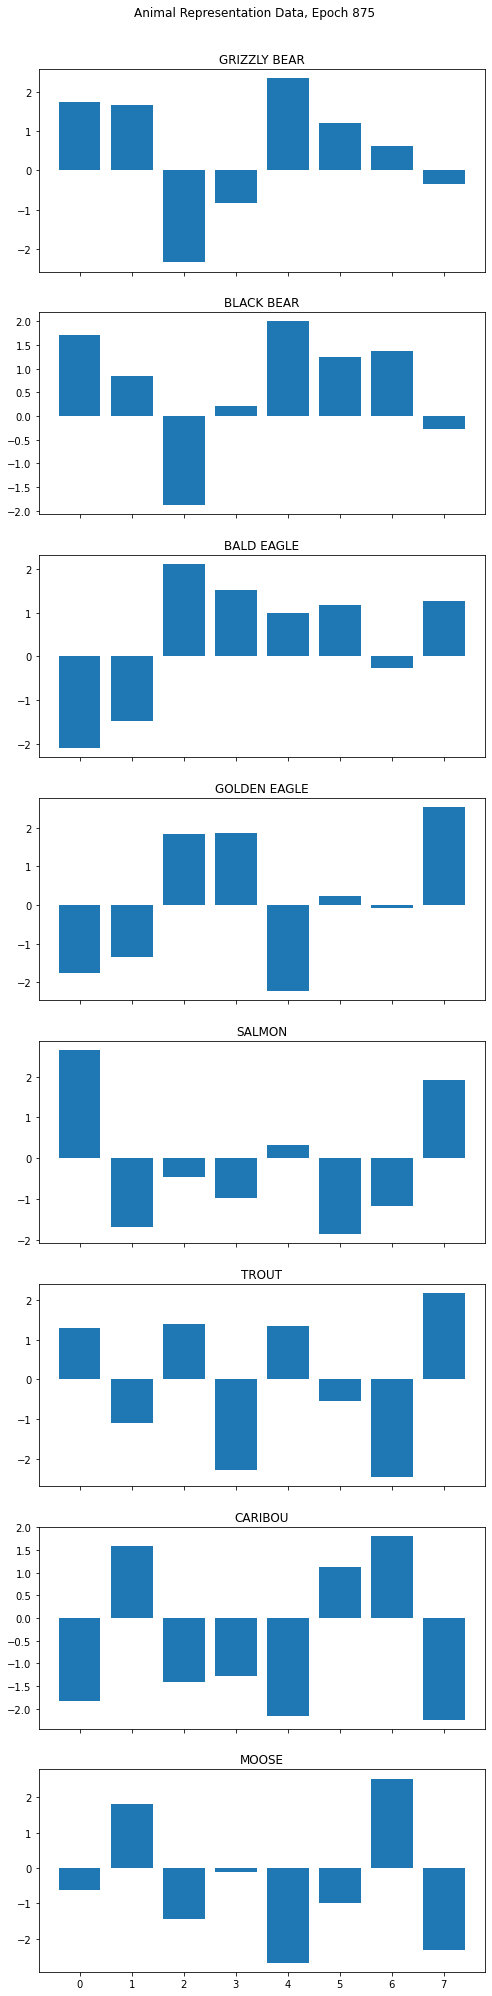

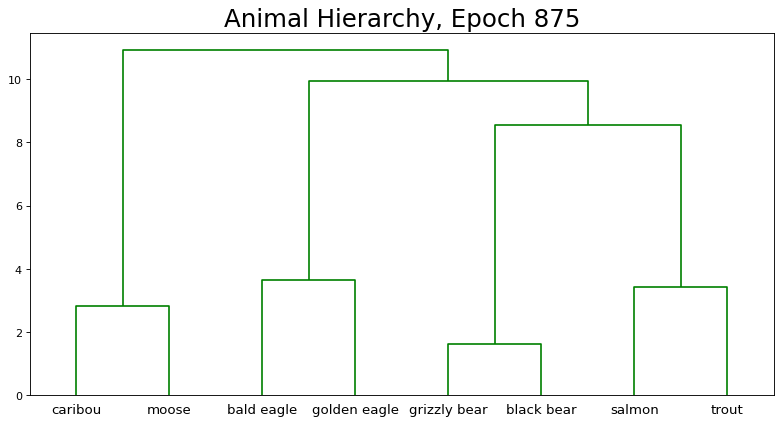

Train Epoch 1050: 	Loss: 7.793617
Test: IS	Average loss = 3.508260
Test: ISA	Average loss = 11.509240
Test: CAN	Average loss = 8.247751
Test: HAS	Average loss = 7.906192


Train Epoch 1225: 	Loss: 7.758016
Test: IS	Average loss = 3.505016
Test: ISA	Average loss = 11.458100
Test: CAN	Average loss = 8.229102
Test: HAS	Average loss = 7.836221


Train Epoch 1400: 	Loss: 7.739257
Test: IS	Average loss = 3.500385
Test: ISA	Average loss = 11.424327
Test: CAN	Average loss = 8.217839
Test: HAS	Average loss = 7.812317


Train Epoch 1575: 	Loss: 7.723432
Test: IS	Average loss = 3.497211
Test: ISA	Average loss = 11.385476
Test: CAN	Average loss = 8.211776
Test: HAS	Average loss = 7.797407


Train Epoch 1750: 	Loss: 7.709515
Test: IS	Average loss = 3.493070
Test: ISA	Average loss = 11.352401
Test: CAN	Average loss = 8.202777
Test: HAS	Average loss = 7.788395




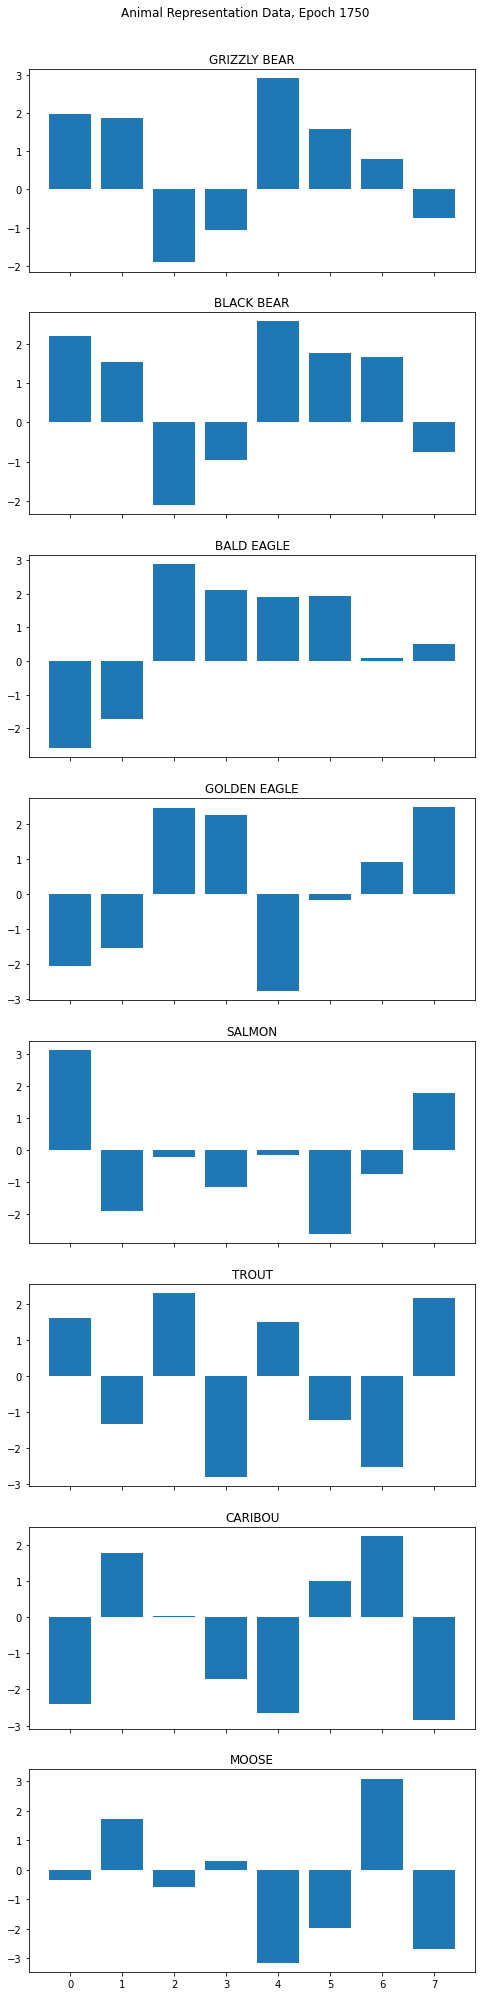

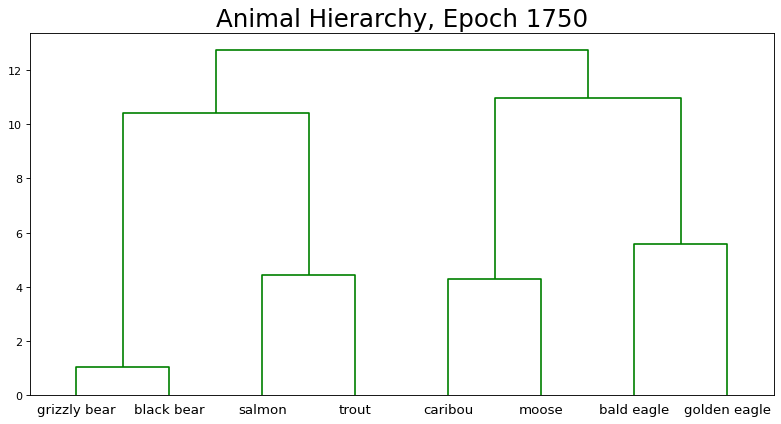

Train Epoch 1925: 	Loss: 7.697578
Test: IS	Average loss = 3.489752
Test: ISA	Average loss = 11.332337
Test: CAN	Average loss = 8.184636
Test: HAS	Average loss = 7.782510


Train Epoch 2100: 	Loss: 7.689702
Test: IS	Average loss = 3.486477
Test: ISA	Average loss = 11.315374
Test: CAN	Average loss = 8.178783
Test: HAS	Average loss = 7.777329


Train Epoch 2275: 	Loss: 7.665127
Test: IS	Average loss = 3.484683
Test: ISA	Average loss = 11.232491
Test: CAN	Average loss = 8.177359
Test: HAS	Average loss = 7.764676


Train Epoch 2450: 	Loss: 7.655498
Test: IS	Average loss = 3.480348
Test: ISA	Average loss = 11.217293
Test: CAN	Average loss = 8.173309
Test: HAS	Average loss = 7.750252


Train Epoch 2625: 	Loss: 7.649925
Test: IS	Average loss = 3.478081
Test: ISA	Average loss = 11.205667
Test: CAN	Average loss = 8.171001
Test: HAS	Average loss = 7.744383




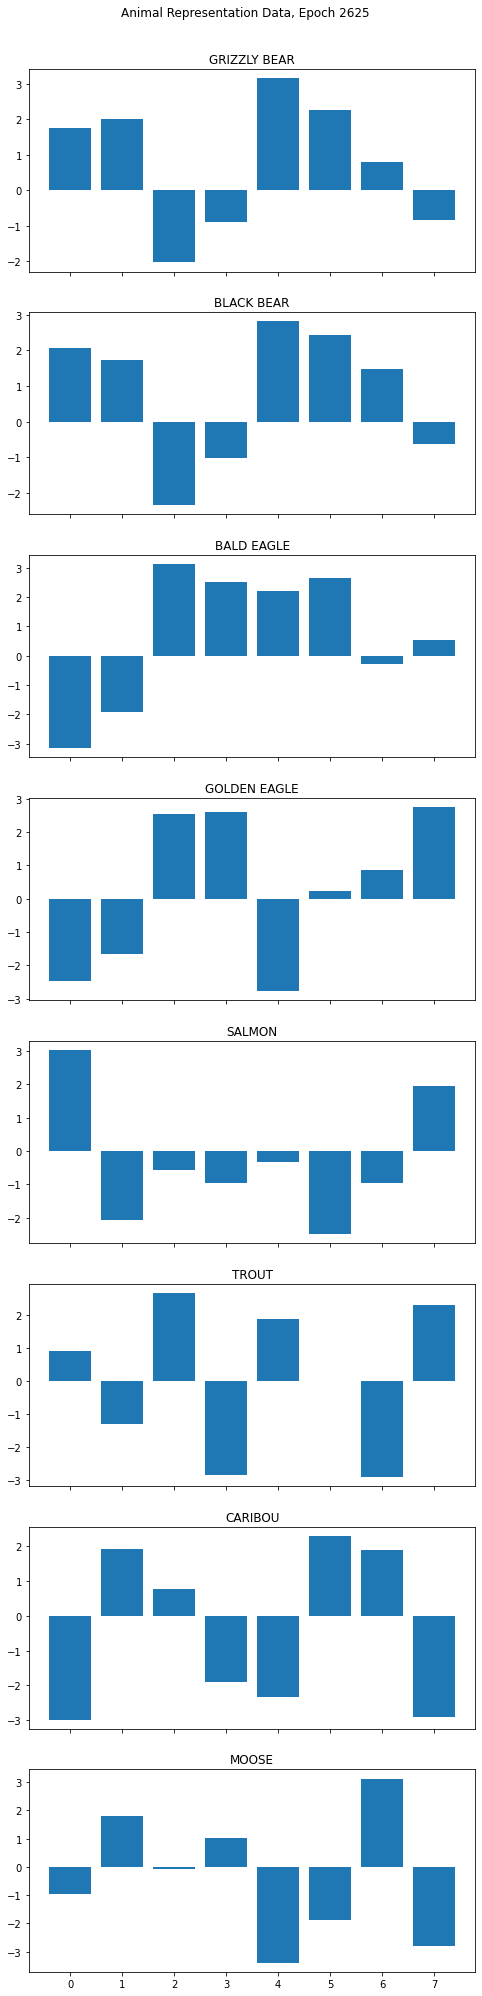

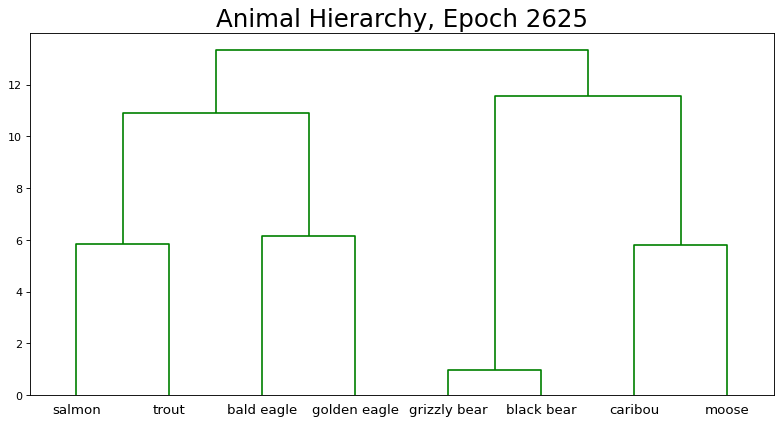

Train Epoch 2800: 	Loss: 7.645894
Test: IS	Average loss = 3.476684
Test: ISA	Average loss = 11.196627
Test: CAN	Average loss = 8.169214
Test: HAS	Average loss = 7.740626


Train Epoch 2975: 	Loss: 7.641228
Test: IS	Average loss = 3.475708
Test: ISA	Average loss = 11.183095
Test: CAN	Average loss = 8.167856
Test: HAS	Average loss = 7.737750


Train Epoch 3150: 	Loss: 7.637379
Test: IS	Average loss = 3.474751
Test: ISA	Average loss = 11.172297
Test: CAN	Average loss = 8.166671
Test: HAS	Average loss = 7.735503


Train Epoch 3325: 	Loss: 7.635036
Test: IS	Average loss = 3.474065
Test: ISA	Average loss = 11.166788
Test: CAN	Average loss = 8.165471
Test: HAS	Average loss = 7.733582


Train Epoch 3500: 	Loss: 7.633174
Test: IS	Average loss = 3.473524
Test: ISA	Average loss = 11.162827
Test: CAN	Average loss = 8.164418
Test: HAS	Average loss = 7.731709




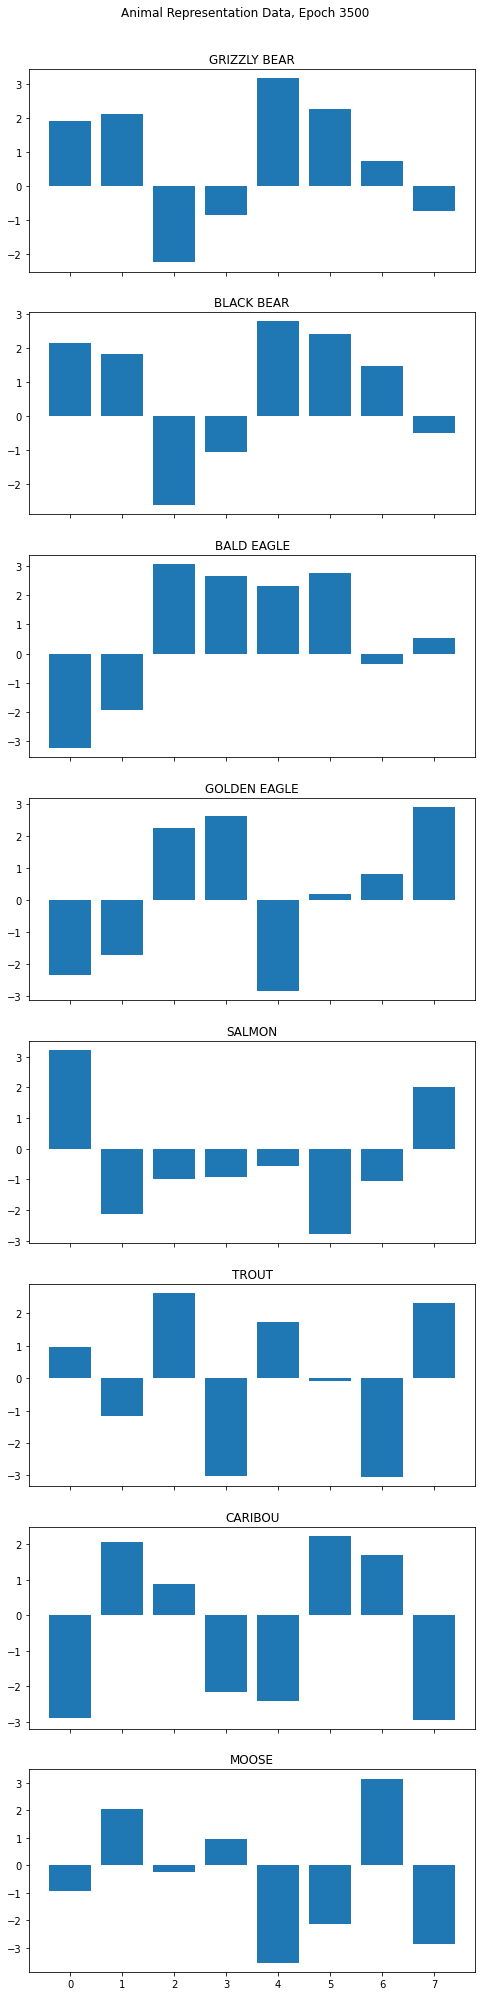

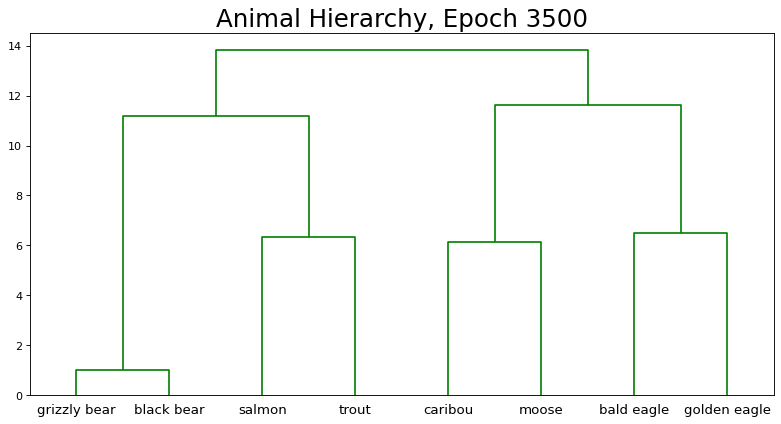

In [ ]:
# Commence training and testing
# Also print out representation graphs every 875 epochs
for epoch in range(1, num_epochs + 1):
  train(epoch)
  test(epoch)
  if (epoch == 1) or (epoch % (num_epochs // 20) == 0):
    print("\n")
  if (epoch == 1) or (epoch % (num_epochs // 4) == 0):
    rep_data_list = create_rep_graphs(epoch)
    create_dendrogram(rep_data_list, epoch)

# Stage 4: Visualizations

In [ ]:
# Create function for making graphs comparing target vs. actual output
# z: specifying which relation's output should be graphed
def create_output_graphs(z):
  with torch.no_grad():
    print("Results for {}:".format(relations_list[z]))
    for index, (data, target) in enumerate(relation_DL_order[z]):
      x, y = data
      output = network(data)
      fig, axs = plt.subplots(figsize=(22,3))
      plt.tight_layout()
      labels = [label if i%2==0 else '\n'+label for i,label in enumerate(attributes_list)]
      axs.plot(labels, output.numpy()[0], 'o', label='output')
      axs.plot(labels, target.numpy()[0], 'o', label='target')
      axs.set_xlabel('\nattributes')
      axs.set_ylabel('value')
      axs.set_title(f"{animals_list[index]}, {relations_list[z]}")
      plt.legend();

Results for IS:


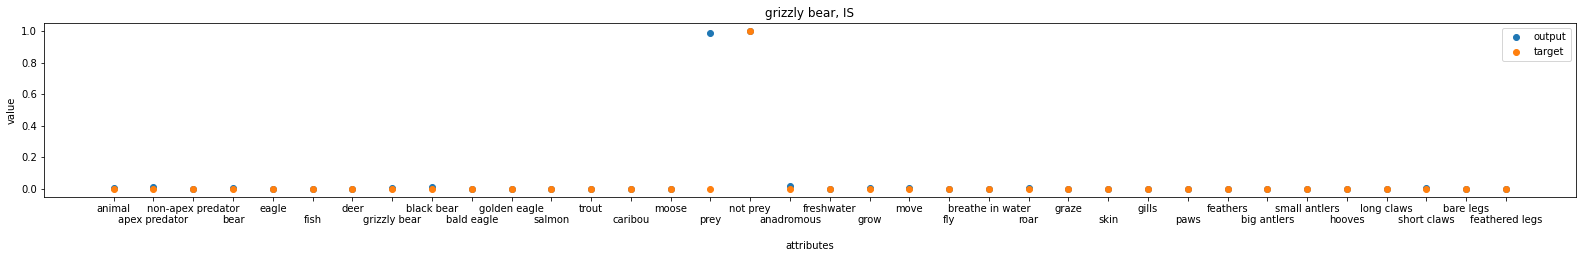

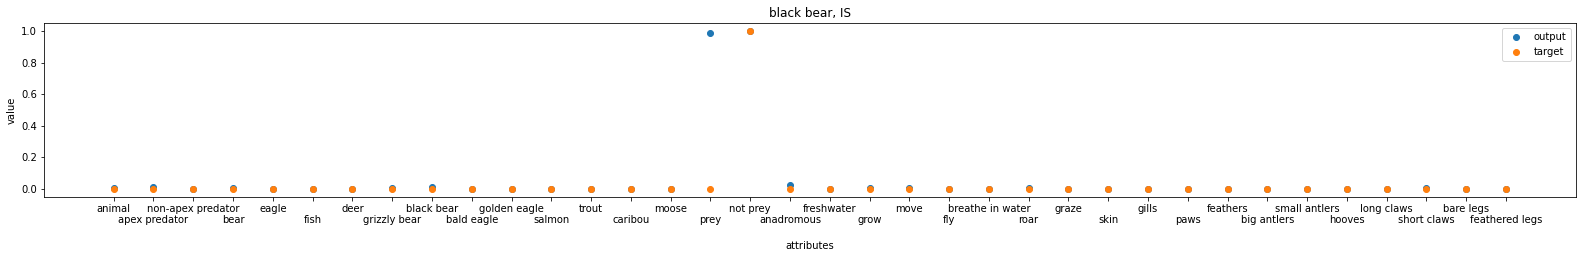

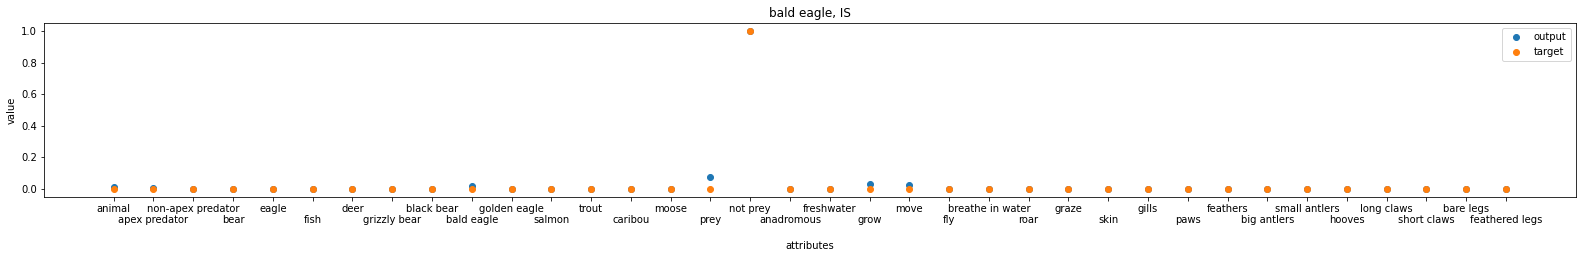

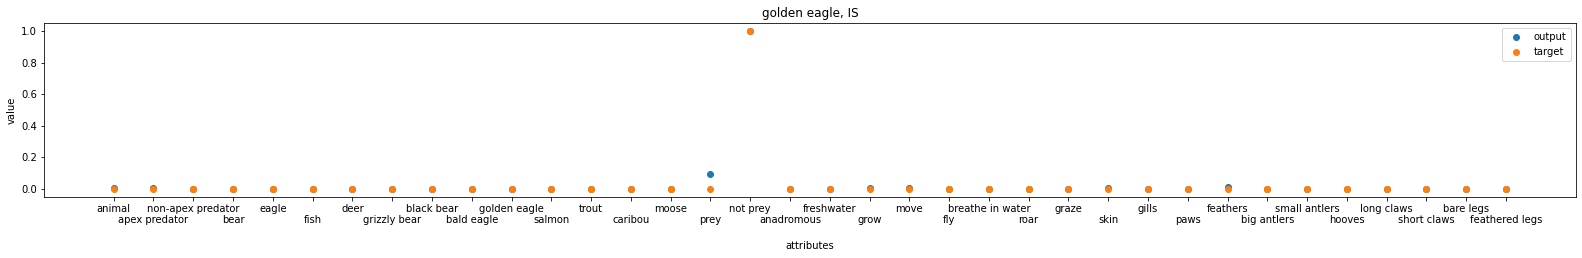

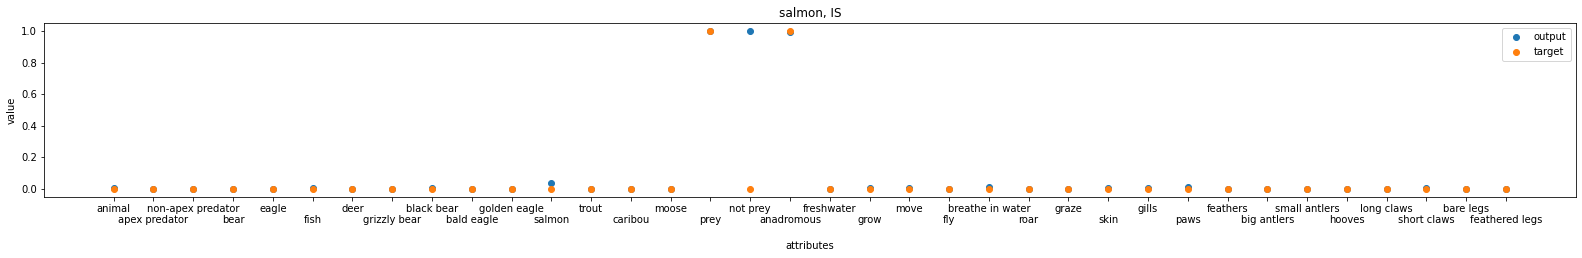

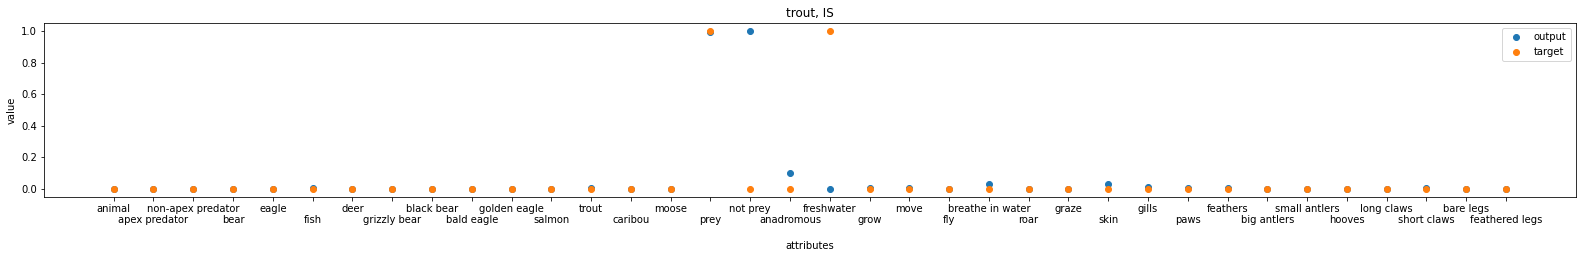

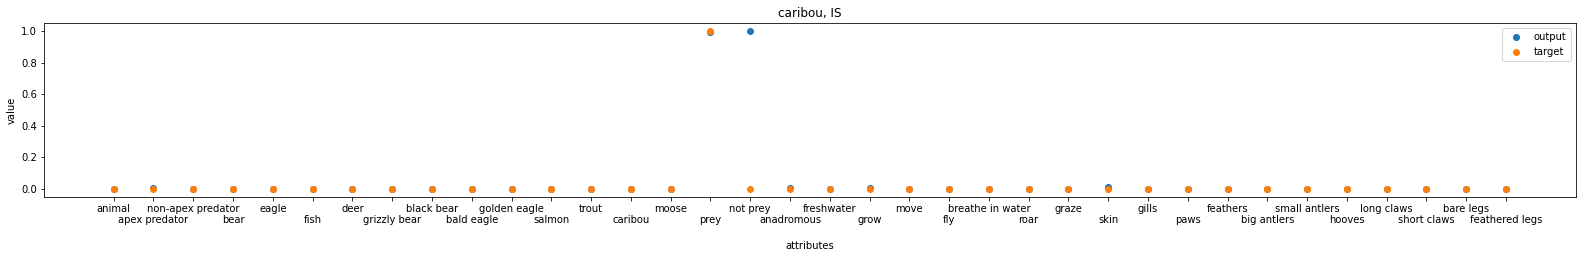

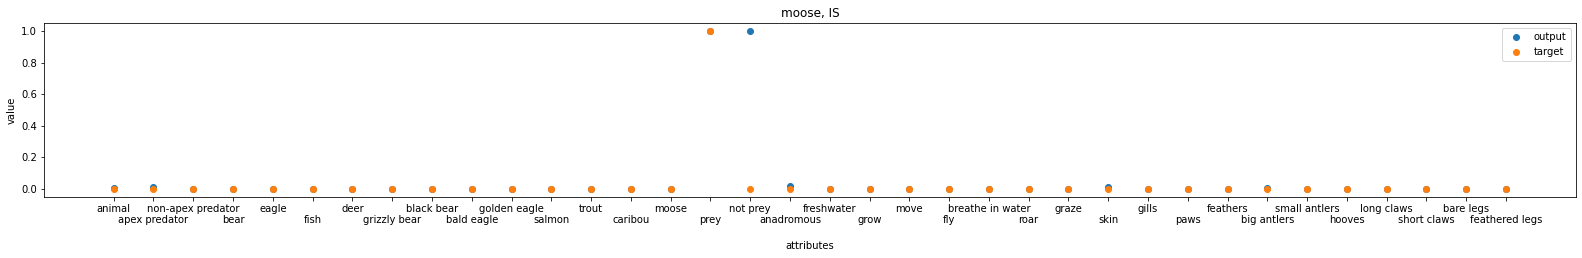

In [ ]:
# Display final results (IS) post-training
create_output_graphs(0)

Results for ISA:


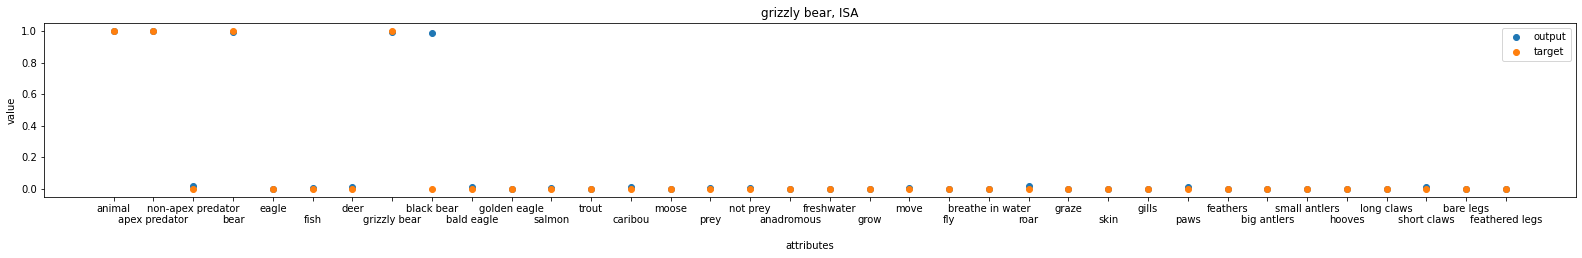

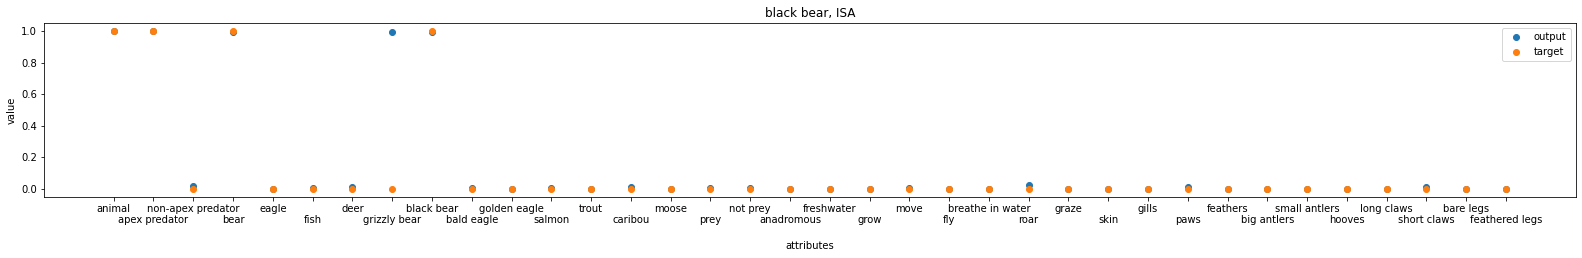

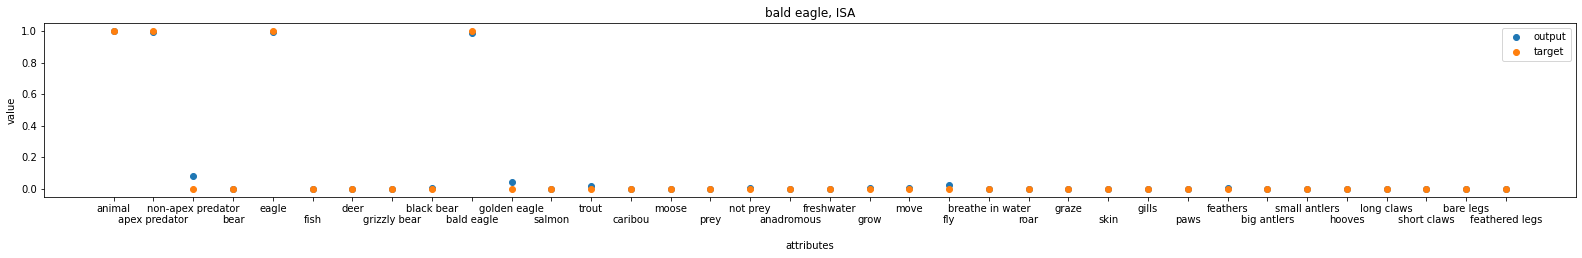

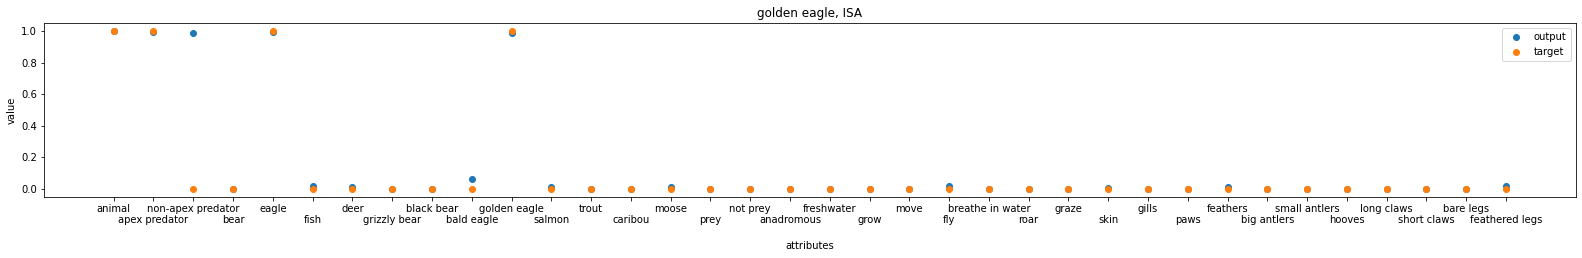

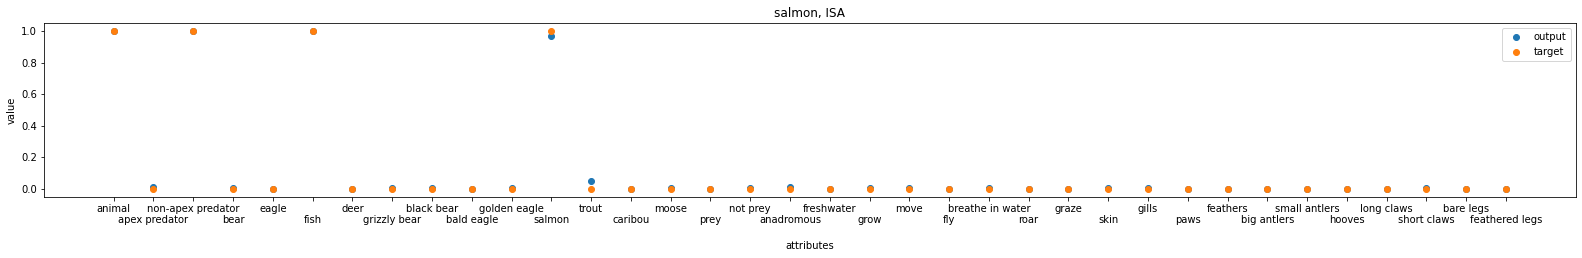

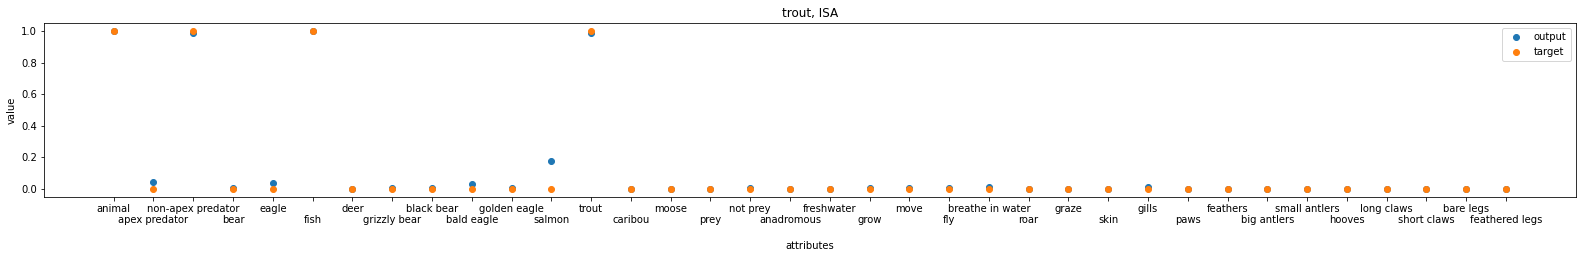

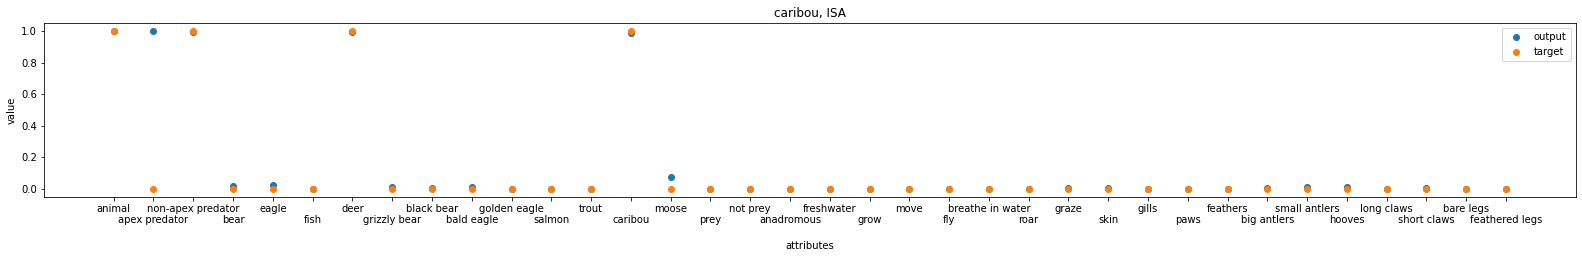

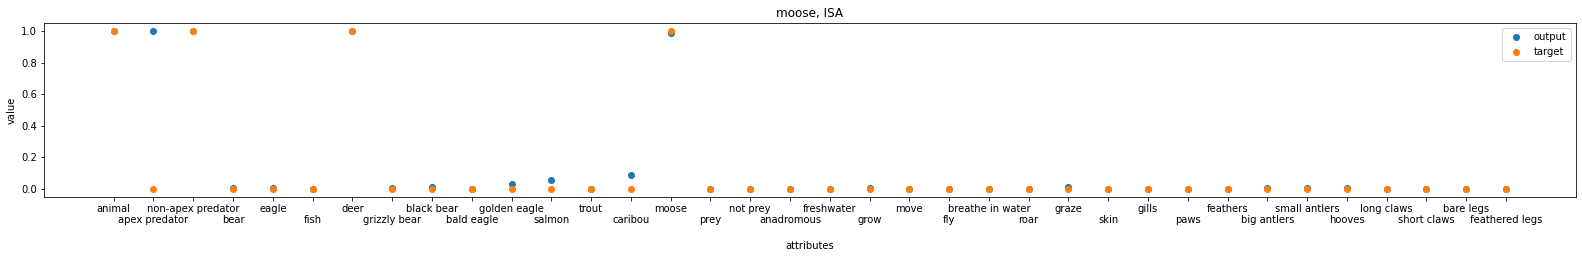

In [ ]:
# Display final results (ISA) post-training
create_output_graphs(1)

Results for CAN:


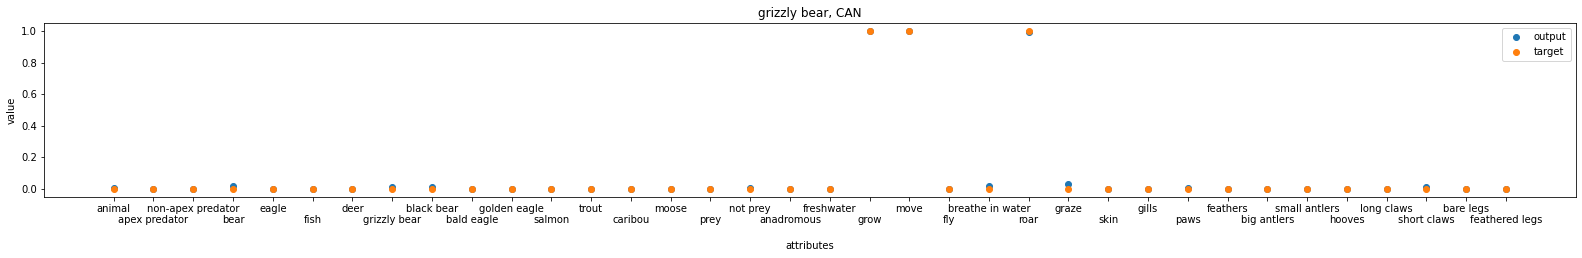

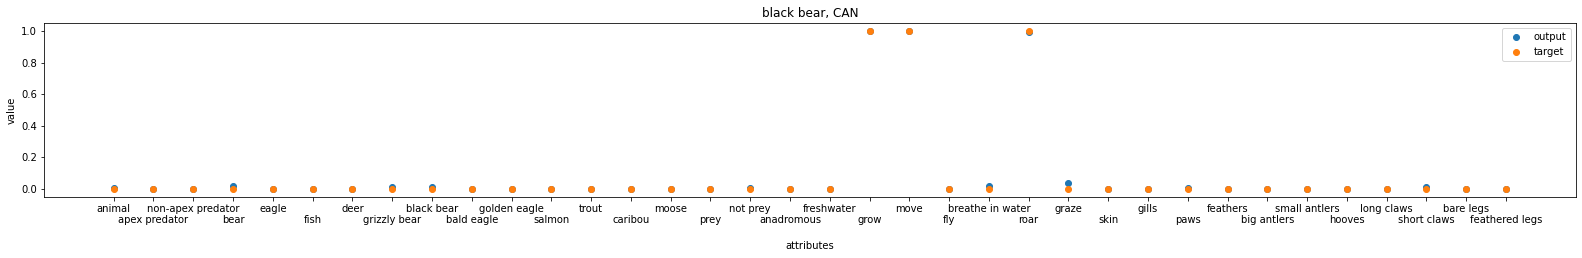

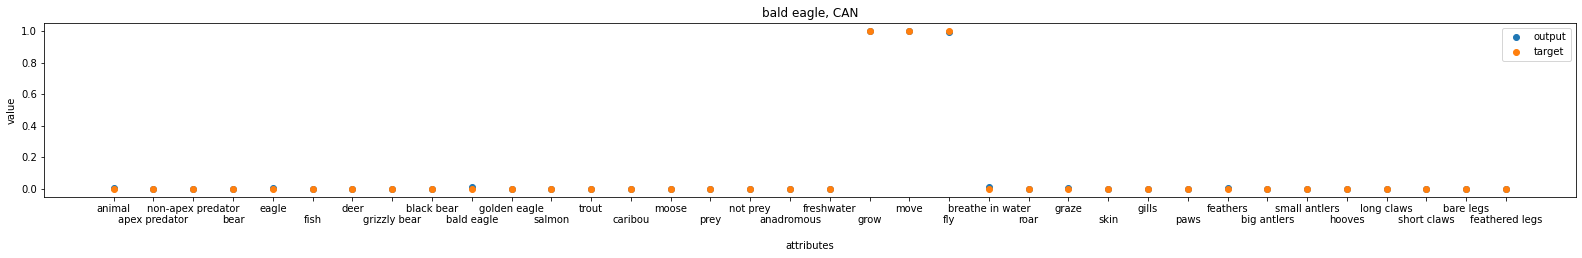

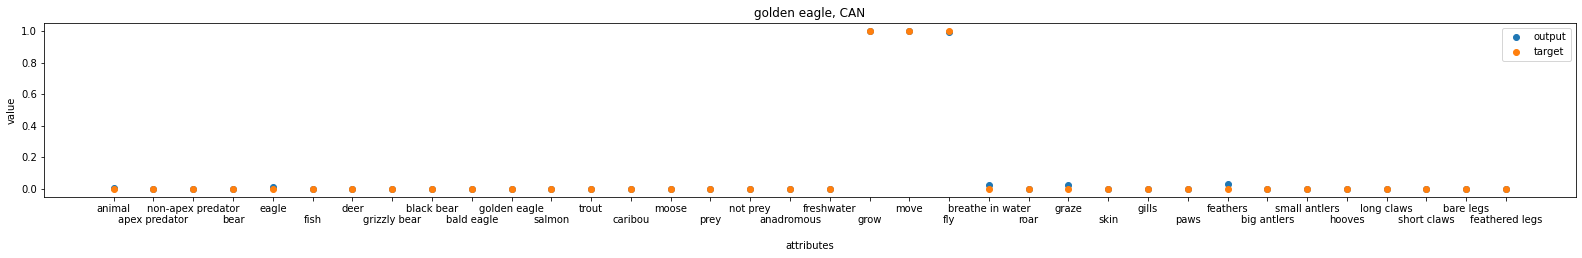

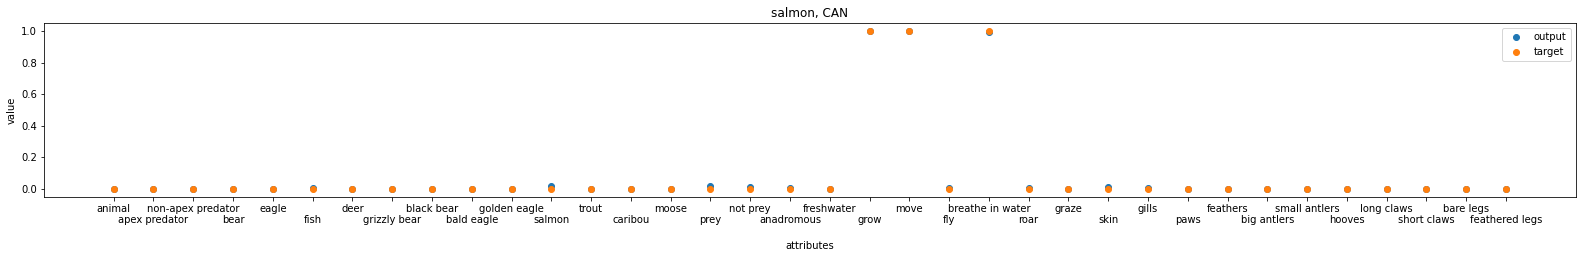

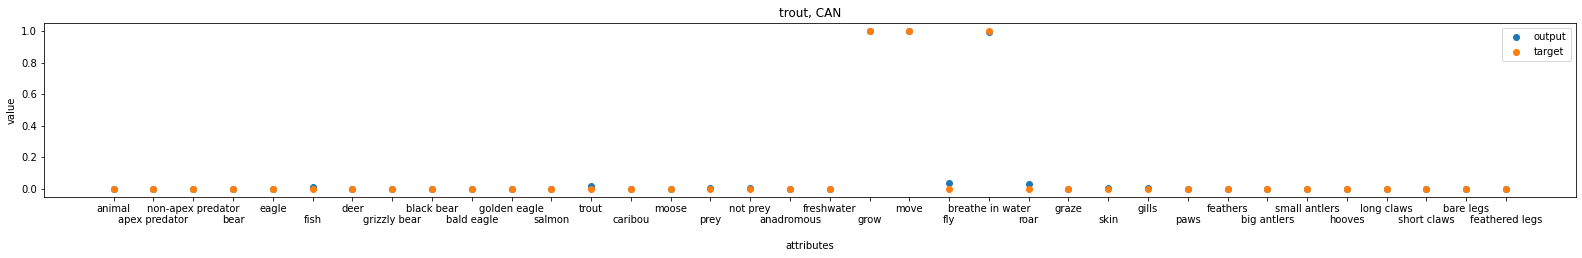

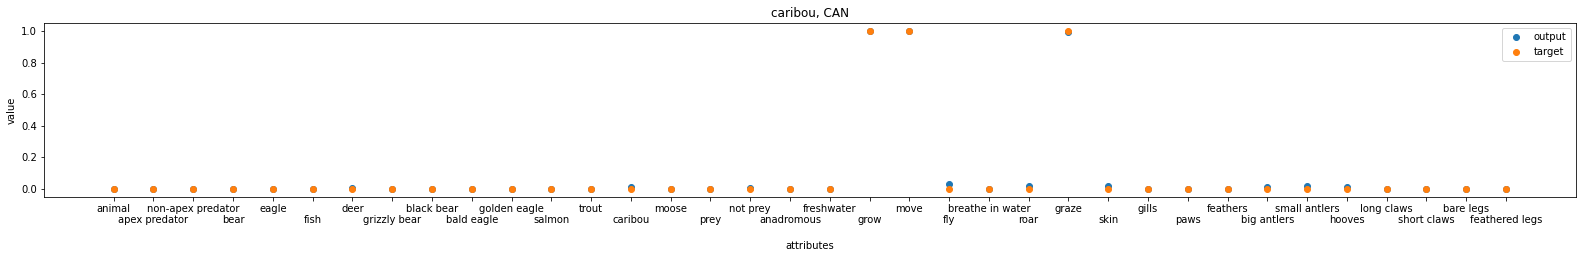

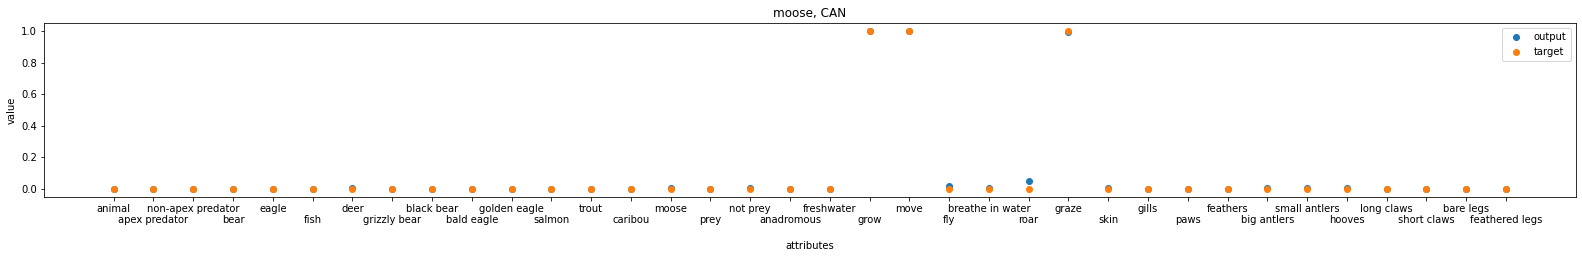

In [ ]:
# Display final results (CAN) post-training
create_output_graphs(2)

Results for HAS:


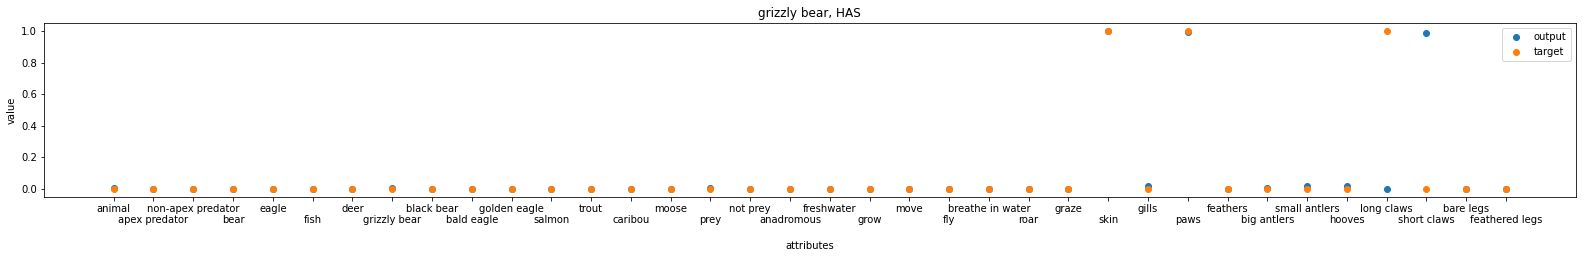

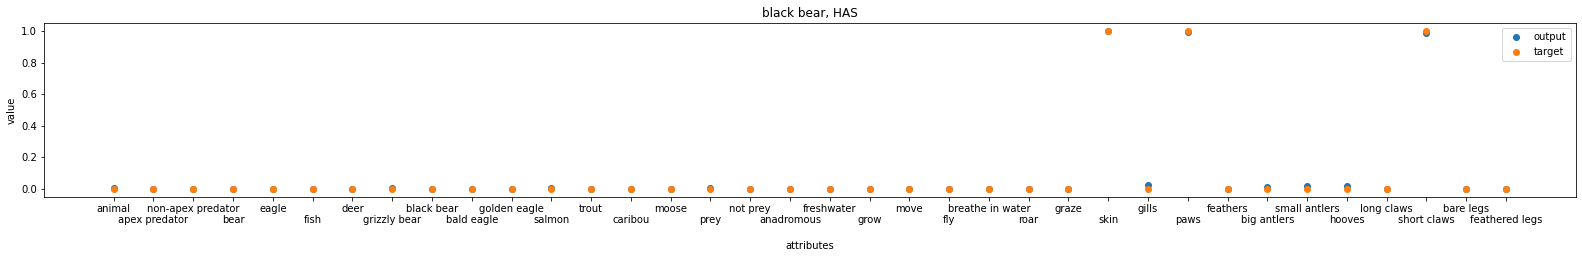

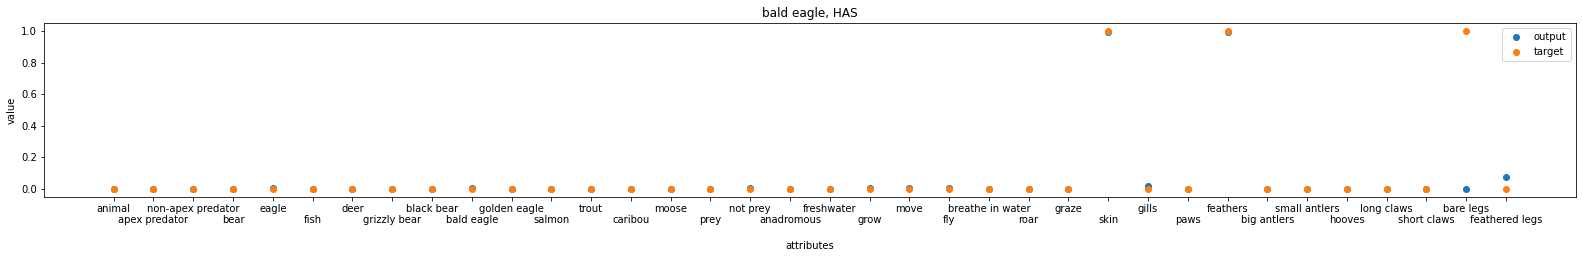

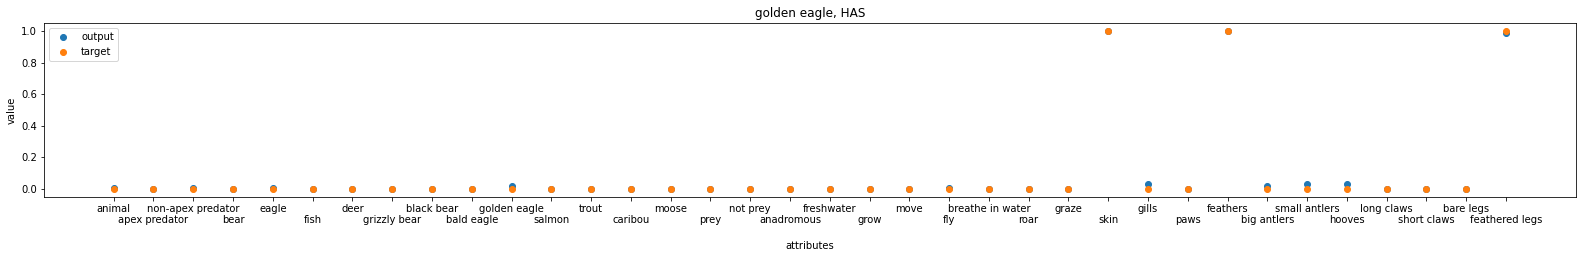

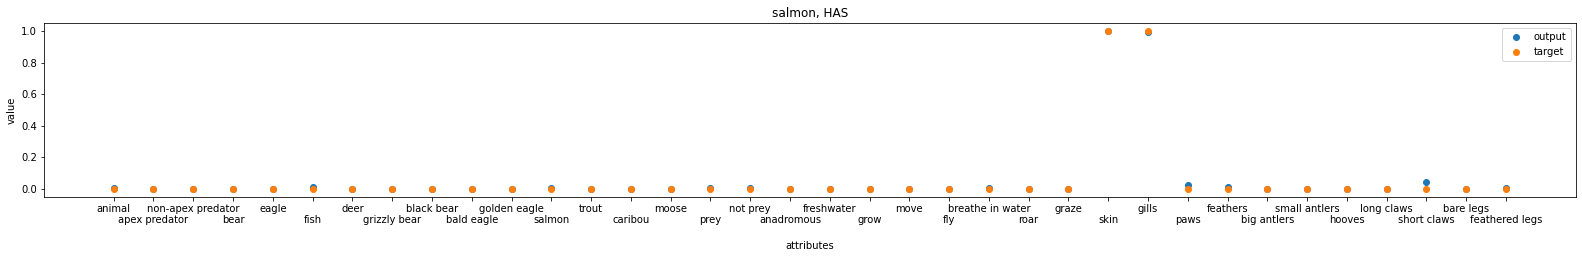

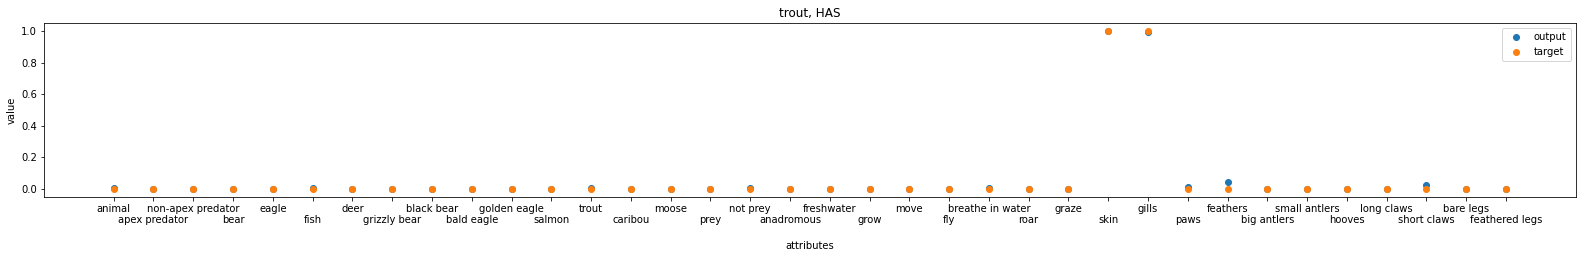

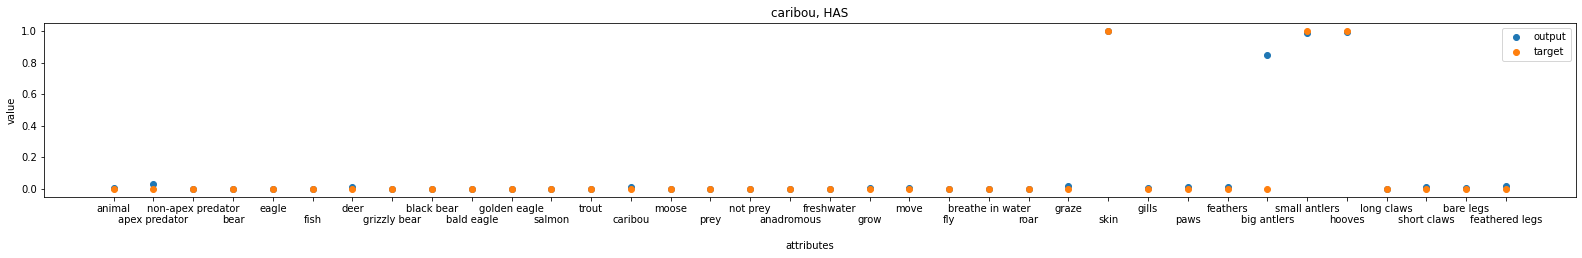

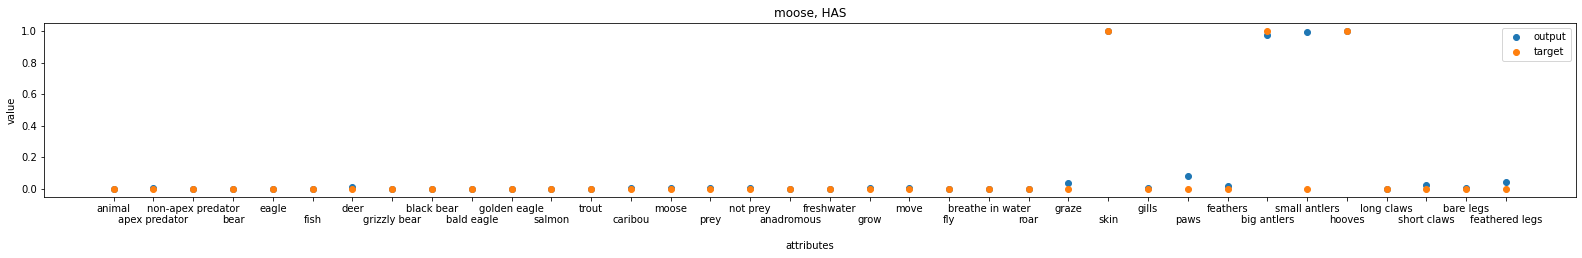

In [ ]:
# Display final results (HAS) post-training
create_output_graphs(3)